In [1]:
import glob
import os
import json
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, median

def get_files(input_dir):
    """
    get all files in a given directory as a list
    """
    return list(map(os.path.basename, glob.glob(input_dir + "/*")))

reports_dir = "../reports/wmt21-04062022"
files = get_files(reports_dir)

## Compare overall BLEU Scores

In [2]:
overall_bleu = {}

for f in files:
    report_pwd = reports_dir + "/" + f
    data=open(report_pwd, "r").read()

    results = json.loads(data)
    bleu_score = results["results"]["overall"]["bleu"]["value"]
    task, lang_pair, orgs, _ = f.split(".")

    if task not in overall_bleu.keys():
        overall_bleu[task] = {}
    elif lang_pair not in overall_bleu[task].keys():
        overall_bleu[task][lang_pair] = {}
    elif "ref" not in orgs:
        overall_bleu[task][lang_pair][orgs] = bleu_score

            

Overall BLEU scores by tasks. Just calculating the mean and max for each language, over submitted systems.

In [3]:
mean_overall_bleu = {}

for key in overall_bleu:
    print("--++--{}--++--".format(key))
    
    task_dict = overall_bleu[key]
    
    
    for k, v in task_dict.items():
        source_lang, target_lang = k.split("-")
        if v:
            print("{}   |   mean: {},    max: {}".format(k, round(mean(v.values()),3), round(max(v.values()),3) ))
            if key not in mean_overall_bleu:
                mean_overall_bleu[key] = {}
            
            mean_overall_bleu[key][k] = mean(v.values())


--++--newstest2021--++--
de-fr   |   mean: 30.098,    max: 37.976
en-ha   |   mean: 17.77,    max: 19.775
ja-en   |   mean: 22.771,    max: 25.933
en-de   |   mean: 35.431,    max: 41.504
is-en   |   mean: 35.164,    max: 40.7
ru-en   |   mean: 37.038,    max: 38.828
en-ja   |   mean: 10.805,    max: 12.668
fr-de   |   mean: 39.347,    max: 56.091
en-zh   |   mean: 9.596,    max: 12.274
zh-en   |   mean: 28.325,    max: 31.106
en-ru   |   mean: 26.546,    max: 28.637
ha-en   |   mean: 16.4,    max: 19.675
en-cs   |   mean: 19.71,    max: 23.489
de-en   |   mean: 36.974,    max: 39.76
en-is   |   mean: 23.512,    max: 31.307
cs-en   |   mean: 22.655,    max: 25.095
--++--florestest2021--++--
xh-zu   |   mean: 11.198,    max: 13.62
hi-bn   |   mean: 12.791,    max: 15.784
bn-hi   |   mean: 20.824,    max: 23.912
zu-xh   |   mean: 10.107,    max: 14.215
--++--tedtalks--++--
en-ru   |   mean: 24.024,    max: 26.312
zh-en   |   mean: 27.093,    max: 66.148
en-de   |   mean: 26.158,    max: 

In [4]:
def calculate_bleu_by_lang(task_dict, lang):
    source_temp = target_temp = source_cnt = target_cnt = 0
    
    for k, v in task_dict.items():
        if k.split("-")[0] == lang:
            source_temp += v
            source_cnt += 1
        if k.split("-")[1] == lang:
            target_temp += v
            target_cnt += 1
            
    try:
        ret = { "{}-xx_average_bleu".format(lang): source_temp/source_cnt,\
             "xx-{}_average_bleu".format(lang): target_temp/target_cnt
        }
    except:
        ret = { "{}-xx_average_bleu".format(lang): -1,\
             "xx-{}_average_bleu".format(lang): -1
           }
            
    return ret

In [5]:
# calculate en-xx as a baseline for comparison purposes for newstest task set, 
# since "en" is paired with most other language

baseline = calculate_bleu_by_lang(mean_overall_bleu["newstest2021"],"en")
baseline

{'en-xx_average_bleu': 20.48157885722917,
 'xx-en_average_bleu': 28.4751710915986}

In [6]:
# german was one other language that appeared more than once in newstest set, so i was curious
calculate_bleu_by_lang(mean_overall_bleu["newstest2021"],"de")

{'de-xx_average_bleu': 33.536154923542185,
 'xx-de_average_bleu': 37.38864775096158}

In [7]:
above_enxx, below_enxx, above_xxen, below_xxen = set(), set(), set(), set()

for key in mean_overall_bleu["newstest2021"]:
    s, t = key.split("-")
    if s == "en":
        if mean_overall_bleu["newstest2021"][key] > baseline['en-xx_average_bleu']:
            above_enxx.add(t)
        else:
            below_enxx.add(t)
    elif t == "en":
        if mean_overall_bleu["newstest2021"][key] > baseline['xx-en_average_bleu']:
            above_xxen.add(s)
        else:
            below_xxen.add(s)

In [8]:
above_enxx

{'de', 'is', 'ru'}

In [9]:
below_enxx

{'cs', 'ha', 'ja', 'zh'}

In [10]:
above_xxen

{'de', 'is', 'ru'}

In [11]:
below_xxen

{'cs', 'ha', 'ja', 'zh'}

Using `en` as a baseline for the `newstest2021` set, it looks like BLEU scores are higher for `{'de', 'is', 'ru'}` and lower for `{'cs', 'ha', 'ja', 'zh'}` in general.


## Plot sentence length vs. BLEU

In [12]:
def plot_bleu(bleu_by_length, label):
    bleus = []
    ranges = []

    for intervals in bleu_by_length:
        bleus.append(bleu_by_length[intervals]["performances"][0]["value"])
        ranges.append(float(intervals[1:-1].split(",")[0]))

    plt.plot(ranges,bleus,label=label)

Since newstest task has the most language pairs, I wanted to use this to compare BLEU scores vs. sentence length for as many languages as possible. For below plots, I used the best performing (in terms of its overall BLEU score) system output to generate the plots for hypothesis, reference and source sentences.

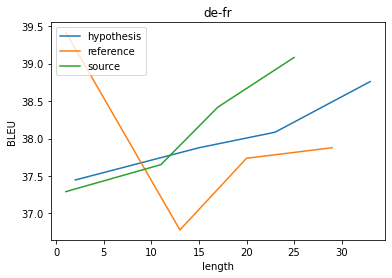

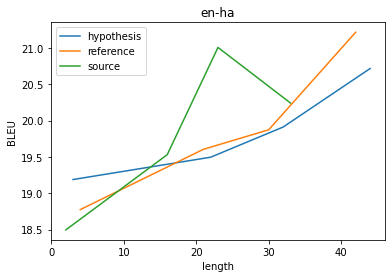

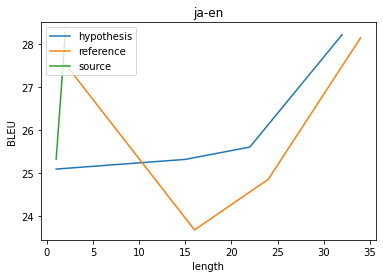

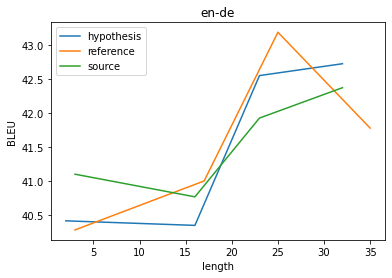

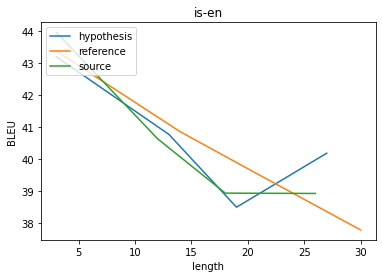

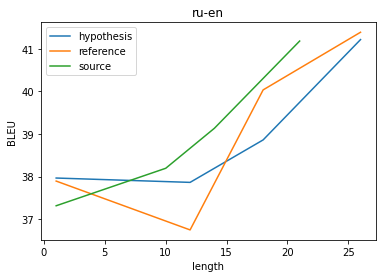

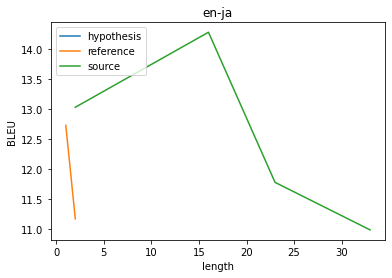

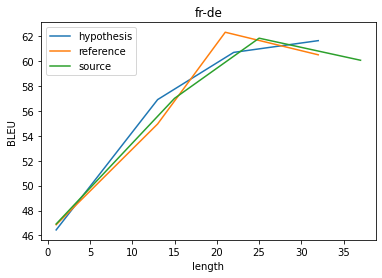

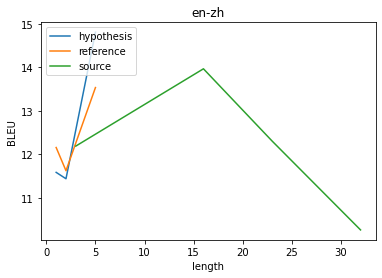

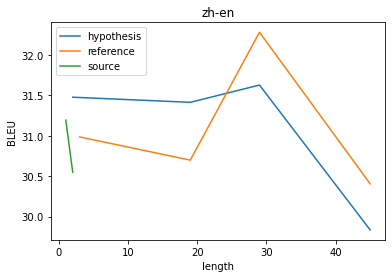

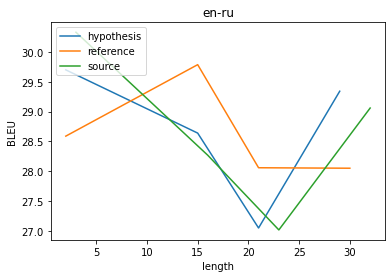

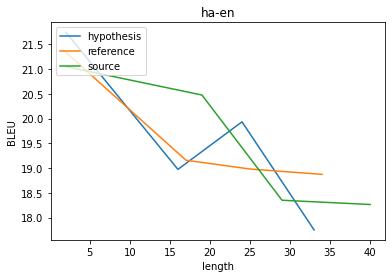

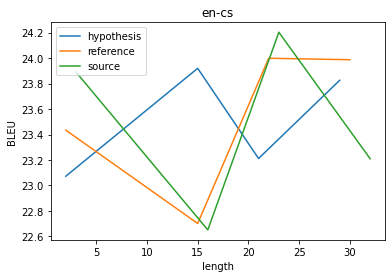

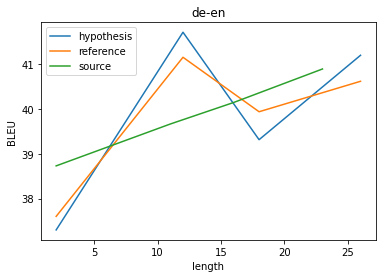

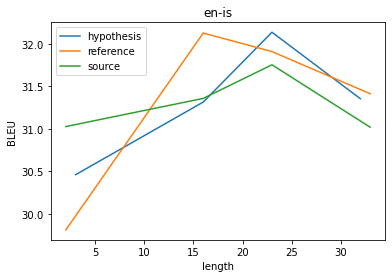

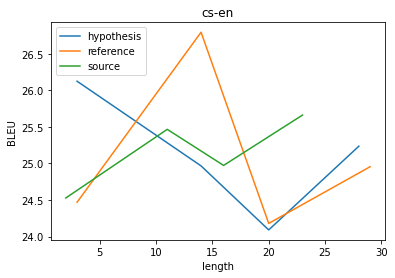

In [15]:
task_name = "newstest2021"

def plot_bleu_vs_length(task_name):
    for lang_pair in overall_bleu[task_name]:
        d = overall_bleu[task_name][lang_pair]
        
        max_value = max(d.values())
        max_key = list(d.keys())[list(d.values()).index(max_value)]

        filename = ".".join([task_name, lang_pair, max_key]) + ".json"

        fig = plt.figure()

        data=open(reports_dir + "/" + filename, "r").read()
        results = json.loads(data)

        plot_bleu(results["results"]["fine_grained"]["hypothesis_length"], label="hypothesis")
        plot_bleu(results["results"]["fine_grained"]["reference_length"], label="reference")
        plot_bleu(results["results"]["fine_grained"]["source_length"], label="source")


        plt.legend(loc="upper left")
        plt.title(lang_pair)
        plt.xlabel("length")
        plt.ylabel("BLEU")
        plt.show()

plot_bleu_vs_length(task_name)

It seems like, for some language pairs, BLEU score trends upward while some trends downward. 
- trend upward: `fr-de`, `en-is`, and `ru-en`
- trend downward: `ha-en`, `is-en`
For most others, BLEU score vs. length trend feels more ambiguous. 

I haven't figured out why this is, but I want to take a closer look at what models were used for each to get an idea. I also think maybe I should take a look at average sentence lengths of the training dataset to see which corpora has long/short sentences for which languages.

Besides newstest2021 set, I also generated plots for remaining tasks

In [16]:
overall_bleu.keys()

dict_keys(['newstest2021', 'florestest2021', 'tedtalks', 'challengeset'])

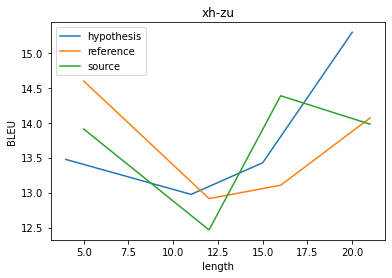

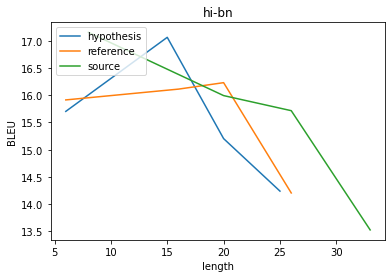

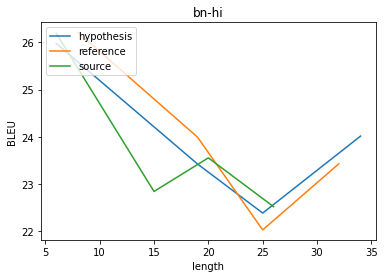

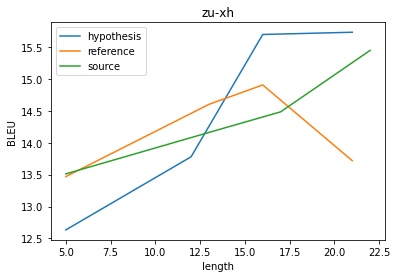

In [17]:
task_name = "florestest2021"
plot_bleu_vs_length(task_name)

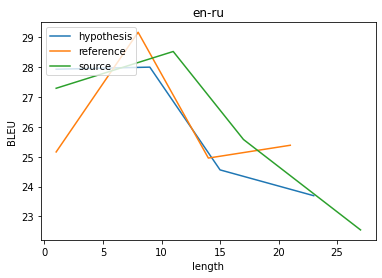

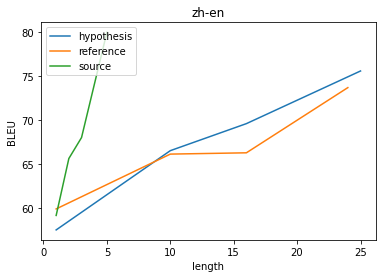

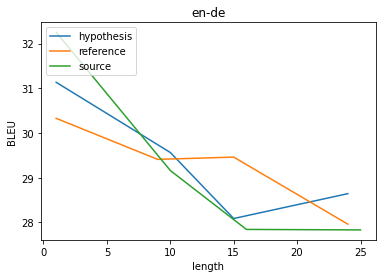

In [18]:
task_name = "tedtalks"
plot_bleu_vs_length(task_name)

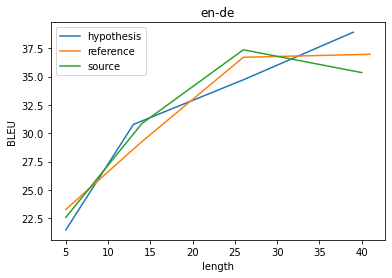

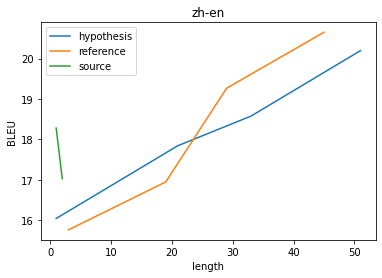

ValueError: max() arg is an empty sequence

In [19]:
task_name = "challengeset"
plot_bleu_vs_length(task_name)

### To Do:
- `challengeset` plotting error? hmm
- better understand token level attributes in the report and figure out how to analyze and plot them.
- processing other datasets right now, run ExplainaBoard on them once I finish
- make use of existing plots in ExplainaBoard
- look into multilingual tasks besides translation

In [20]:
# misc.

def split_files_by_languages(files):
    files_by_languages = defaultdict(list)

    for f in files:
        lang_pair = f.split(".")[1]
        files_by_languages[lang_pair].append(f)
    return files_by_languages